In [1]:
# importing  libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import warnings
import pymc3 as pm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.


In [4]:
# pip install scikit-learn

In [135]:
pip install --upgrade pandas


Note: you may need to restart the kernel to use updated packages.


In [137]:
# loading data 

file_id = '1QqVQ5ZtyE--EExYNZ6Q8eKh1Xrw3IB6X'
direct_url = f'https://drive.google.com/uc?id={file_id}'

avacado_dataset = pd.read_csv(direct_url)

In [138]:
avacado_dataset.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


## Data Prep ##

In [141]:
# Drop columns
avacado_dataset.drop(columns = "Unnamed: 0" , inplace = True)

In [339]:
# adding conventional and non - conventional flag
avacado_dataset.loc[:,'conventional_type'] = np.where(avacado_dataset['type'] == 'conventional' , 1 , 0)

#trimmed data
df = avacado_dataset.loc[:,['Date','AveragePrice' , 'conventional_type' , 'Total Volume']]

# converting date to datetime
df['Date'] = pd.to_datetime(df['Date'] ,  format='%Y-%m-%d')

# extracting year
df['Year'] = df['Date'].dt.year

# filter for a year and conventional type
df_1 = df[(df['Year'] == 2017) & df['conventional_type'] == 1]

# sort by date
df_1 = df_1.sort_values(by = 'Date')

# reset index
df_1 = df_1.reset_index(drop = True)

# rename total volume 

df_1.rename(columns = {'Total Volume' : 'Total_volume'} , inplace = True)

In [341]:
# data check 

df_1['conventional_type'].value_counts()

conventional_type
1    2862
Name: count, dtype: int64

In [343]:
# aggregation at a date level 
df_2 = df_1.groupby(('Date'), ).agg({'AveragePrice' : 'mean' , 'Total_volume' : 'sum'})
df_2.reset_index(inplace = True)
df_2.rename(columns = {'AveragePrice' : 'Avg_Price' , 'Total_volume' : 'Total_volume'} , inplace = True)
df_2.sort_values(by = 'Date' , inplace = True)
df_2.head()

,Date,Avg_Price,Total_volume
0,2017-01-01,0.985926,1.022769e+08
1,2017-01-08,1.060000,1.007855e+08
2,2017-01-15,1.087778,1.012323e+08
3,2017-01-22,1.020926,1.120891e+08
4,2017-01-29,1.063148,1.043100e+08


## Viz 

<Figure size 2000x500 with 0 Axes>

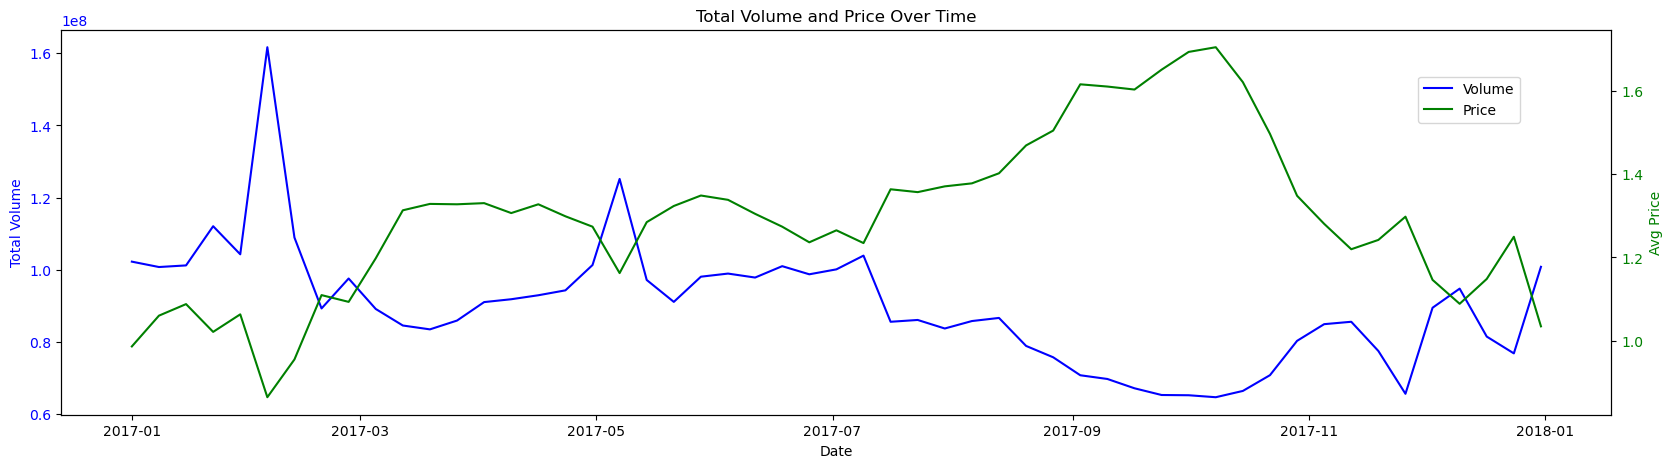

In [293]:
plt.figure(figsize=(20, 5))

# Create the first y-axis
fig, ax1 = plt.subplots(figsize=(20, 5))
ax1.plot(df_2['Date'], df_2['Total_volume'], label='Volume', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Volume', color='blue')
ax1.set_title('Total Volume and Price Over Time')
ax1.tick_params(axis='y', labelcolor='blue')

# Create the second y-axis
ax2 = ax1.twinx()
ax2.plot(df_2['Date'], df_2['Avg_Price'], label='Price', color='green')
ax2.set_ylabel('Avg Price', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legend
fig.legend(loc="upper left", bbox_to_anchor=(0.8, 0.8))

plt.show()


<Axes: xlabel='Avg_Price', ylabel='Density'>

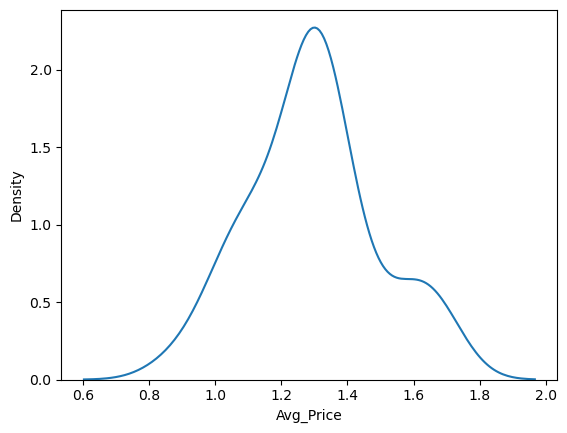

In [297]:
sns.kdeplot(df_2['Avg_Price'])

In [16]:
df_1['AveragePrice'].mean()

1.5151275777700106

<Axes: xlabel='Total_volume', ylabel='Density'>

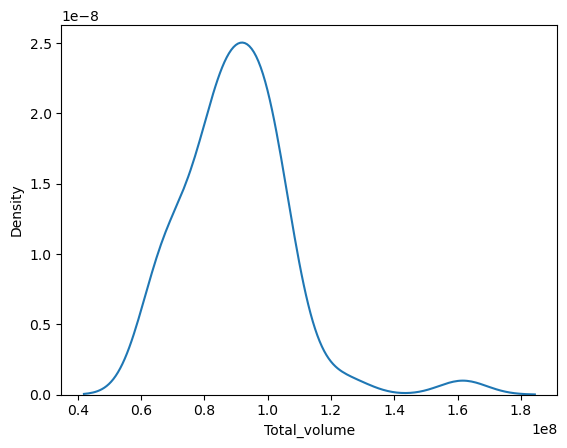

In [299]:
sns.kdeplot(df_2['Total_volume'])

## Bayesian Model

In [337]:
df_2.columns

Index(['Date', 'Avg_Price', 'Total_volume', 'scaled_volume', 'scaled_price'], dtype='object')

In [333]:
# standardising the variables 

# StandardScaler instance
# scaler = MinMaxScaler()

# Fit and transform the selected columns, then assign to new columns in the DataFrame
# df_2.loc[:, ['scaled_volume', 'scaled_price']] = scaler.fit_transform(df_2.loc[:, ['Total_volume', 'Avg_Price']])



In [352]:
# scaling back volume 

df_2['scaled_volume'] = df_2['Total_volume']/10000000.0

# train test spit 
train_df, test_df = train_test_split(df_2, test_size=0.2, random_state=42)

In [70]:
# Finding the mean and std of scaled variables 

#price_mean = (scaler.mean_[1])
#price_std = np.sqrt(scaler.var_[1])

#volume_mean = scaler.mean_[0]
#volume_std = np.sqrt(scaler.var_[0])


In [354]:
train_df.describe()

,Date,Avg_Price,Total_volume,scaled_volume
count,42,42.000000,4.200000e+01,42.000000
mean,2017-07-02 16:00:00,1.302553,8.895637e+07,8.895637
min,2017-01-01 00:00:00,0.954630,6.472293e+07,6.472293
25%,2017-04-10 18:00:00,1.171296,8.007869e+07,8.007869
50%,2017-07-05 12:00:00,1.302037,8.940919e+07,8.940919
75%,2017-09-22 06:00:00,1.369352,9.892106e+07,9.892106
max,2017-12-31 00:00:00,1.705926,1.251862e+08,12.518618
std,NaN,0.192257,1.349603e+07,1.349603


In [358]:
## Fiting the model 

# specifying the formula 

formula = "scaled_volume ~ Avg_Price" 

# Fitting the Bayesian model 

with pm.Model() as volume_prediction_model:
    prior = {"Avg_Price" : pm.Normal.dist(mu = 0 , sigma = 5)}
    pm.GLM.from_formula(formula , data = train_df[['scaled_volume','Avg_Price']] , priors = prior)
    
    # sample posterior draws
    trace = pm.sample(draws=2000,tune = 1000 , init="adapt_diag" ) 

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
C:\Users\abhin\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:232: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, Avg_Price, Intercept]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


C:\Users\abhin\AppData\Local\Temp\ipykernel_19580\497440314.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\abhin\anaconda3\envs\pymc3_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


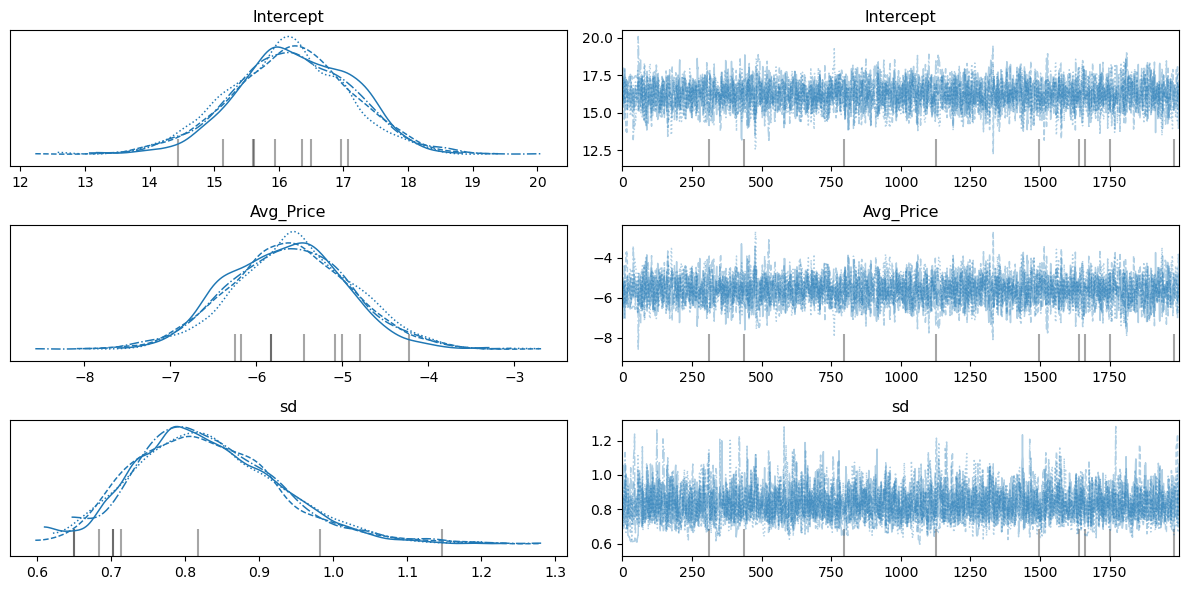

In [414]:
# Viz the traceplots (The posterior plots) 

pm.traceplot(trace)
plt.tight_layout()

plt.savefig("Trace PLot.jpg")
plt.show()

In [362]:
# trace summary
trace_summary = az.summary(trace)
print(trace_summary)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\abhin\anaconda3\envs\pymc3_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  16.203  0.913  14.576   17.994      0.019    0.013    2399.0   
Avg_Price  -5.608  0.692  -6.947   -4.363      0.014    0.010    2385.0   
sd          0.832  0.098   0.646    1.004      0.002    0.002    1835.0   

           ess_tail  r_hat  
Intercept    2425.0    1.0  
Avg_Price    2264.0    1.0  
sd           1220.0    1.0  


In [158]:
# mean of the coefficients 
#intercept_mean = trace.get_values("Intercept").mean()
#scaled_price_mean = trace.get_values("scaled_price").mean()
#conventional_type = trace.get_values("conventional_type").mean()
#sd_mean = trace.get_values("sd").mean()

In [372]:
# raw values of the draws 
intercept_posterior_draws = trace.get_values("Intercept") 
price_posterior_draws = trace.get_values("Avg_Price") 
sd_posterior_draws = trace.get_values("sd") 

In [374]:
# different average price combinations to test

price_options = np.arange(0.5,2.75,0.25)


In [384]:
# assumimg a profit margin of 20 percent o

# generating profit distributions for every price options we have
check = []
profits = {}

for i in range(0,len(price_options)):

    # using the scaled variables
    pred_volume_mean = (intercept_posterior_draws + price_posterior_draws*price_options[i] )
    
    pred_volume_scaled = np.random.normal(pred_volume_mean,sd_posterior_draws,size = 8000)

    pred_volume = pred_volume_scaled*10000000.0

    # using unscaled variables 
    # 10 percent profit per every sale for <=1.5 else 20 percent profit
    
    if(price_options[i]<=1.5):
        pred_profit = pred_volume*price_options[i]*0.1
    else:
         pred_profit = pred_volume*price_options[i]*0.2

    profits.update({price_options[i] : pred_profit})


C:\Users\abhin\AppData\Local\Temp\ipykernel_19580\2473621573.py:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(profits , hdi_prob=0.95)


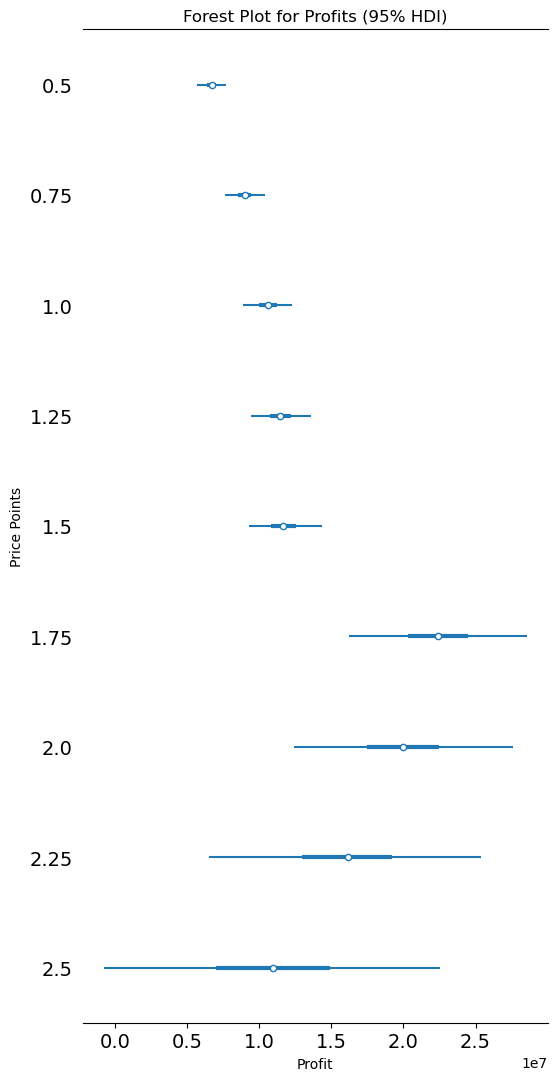

In [412]:
pm.forestplot(profits , hdi_prob=0.95)
plt.title("Forest Plot for Profits (95% HDI)")
plt.xlabel("Profit")
plt.ylabel("Price Points")
plt.savefig("Forest Plot.jpg")